In [1]:
# 라이브러리 호출 및 저장
import bok_da as bd
import numpy as np
import pandas as pd
import scipy.stats as sp
import matplotlib.pyplot as plt
import seaborn as sns

#### 본 매뉴얼에서는 시계열 변수의 자가상관함수 추정 및 백색잡음(white noise)과정 검정에 대해 다룬다.
- 작성자: 고려대학교 경제학과 강규호 교수, 디지털신기술팀 이창훈 과장

## 1. 구성함수 (상위함수와 사용되는 하위함수)

- `white_noise`: 단변수에 대한 백색잡음과정 결합 가설 검정 (Box-Pierce 및 Ljung-Box 검정)

    - `autocov`: 단변수에 대한 자기공분산 (autocovariance) 추정

    - `autocor`: 단변수에 대한 자기상관계수 (autocorrelation) 추정 및 백색잡음과정 단순 가설 검정
    
- `ar`: 단변수 AR(p) 모형에 대한 OLS 추정

## 2. 데이터 불러오기

데이터는 한국의 전기대비 실질 GDP 성장률, CD91일 금리, 인플레이션율 소비자 가격 지수 (Consumer Price Index, CPI), CD91일 금리로 1999년 4분기부터 2023년 4분끼지의 분기별 자료이다. 해당 데이터는 ECOS (https://ecos.bok.or.kr/#/)에서 다운로드 받았으며 컴퓨터에 "python_data.xlsx"라는 이름의 엑셀파일의 "KORmacro"라는 시트에 저장되어 있다. 이때, 인플레이션율의 경우 소비자 가격 지수 (Consumer Price Index, CPI)의 전년동기대비 치분 (YoY)을 통해 미리 변환한 것이다.

`data` 폴더에서 `python_data.xlsx`를 불러온 후 파이썬 표준 자료형인 `pandas.DataFrame`으로 전처리를 수행한다. `DataFrame`은 테이블 형태의 데이터의 행(날짜)과 열(변수명) 정보를 가지고 있어, 행렬이나 벡터형태로 분석하는 것보다 유용하다. `df`라는 이름으로 할당하는 것이 일반적이다. 데이터프레임에 익숙하지 않은 경우 아래 셀의 코드를 줄별로 여러 셀로 나누어 실행해보는 것을 추천한다. 원천기관에서 raw 데이터를 불러오고 전처리하는 과정이 복잡해 보일 수 있지만, 한번 해두면 크게 코드를 수정할 필요없이 새로운 데이터에 대해서도 분석 가능한 형태로 전처리 할 수 있기 때문에 장기적으로 효율적인 방법이다.

In [2]:
df = pd.read_excel('data/python_data.xlsx', sheet_name='KORmacro') # 데이터 엑셀파일 불러오기
df = df.set_index('date') # date 명의 열을 인덱스로 지정한다.
df.index.name = None # 인덱스 이름 date를 제거한다.
df.index = df.index.str.replace('/', '-') # 2000/03 형식을 pandas가 날짜로 인식하도록 2000-3형식으로 변환한다.
df.index = pd.to_datetime(df.index) + pd.offsets.QuarterEnd(0) # 인덱스(행)를 날짜로 인식하도록 변환한다.
df.index.freq = pd.offsets.QuarterEnd() # 인덱스의 frequency를 분기말(2000-03-31)로 설정한다.
column_order = ['inf', 'rgdp', 'cd91'] # df의 열 순서를 리스트로 미리 할당
df = df[column_order] # df의 열 순서를 column_order에 맞게 변경
df

,inf,rgdp,cd91
2000-12-31,2.508257,-0.3,6.97
2001-03-31,3.627876,1.2,5.95
2001-06-30,4.919778,1.3,5.78
2001-09-30,4.158456,1.4,4.97
2001-12-31,3.244327,1.8,4.58
...,...,...,...
2022-12-31,5.083054,-0.3,3.91
2023-03-31,4.496285,0.3,3.64
2023-06-30,3.212650,0.6,3.63
2023-09-30,3.079117,0.6,3.74


## 3. 자기상관함수 (Autocorrelation function, ACF) 추정

`bok_da` 라이브러리-시계열분석 패키지(`ts`)-시계열 검정 서브패키지(`test`)의 `autocor`라는 함수를 사용하면 아래와 같이 확률과정의 자기공분산 및 자기상관함수를 추정할 수 있다. 이때 `autocor` 함수는 다음과 같이 구성되어 있다.
> *<p style="font-size:15px">`res = autocor(X, tau_max=None)`</p>*
> *<p style="font-size:15px">단변수 확률과정의 자기상관함수 추정 및 백색잡음과정 단순 검정</p>*
> - **입력**:
    </br>
    X: 추정하고자 하는 변수 (단변수)
    </br>
    tau_max: 자기상관함수 추정에 사용되는 최대 시차 (default = 20)
    </br>
> - **출력**:
    </br>
    cor: 추정된 자기상관함수 행렬, $tau\_max \times 1$
    </br>
    bound: 2 표준 오차 한도
    </br>



---

한편, `autocor` 함수와 함께 사용되는 `autocov`함수는 아래와 같이 구성되어 있다.

>> *<p style="font-size:15px">`cov = autocov(X, tau_max)`</p>*
>> *<p style="font-size:15px">단변수 확률과정의 자기공분산함수 추정</p>*
>> - **입력**:
</br>
    X: 추정하고자하는 변수(단변수)
    </br>
    taumax: 자기공분산 추정에 사용되는 최대 시차 (default = 20)
    </br>
>> - **출력**:
</br>
    cov: 추정된 자기공분산 함수 행렬
    </br>


#### 설명
백색잡음과정은 $\rho_{h}=0$이라는 특성을 이용하여 표본 자기상관함수에 대해 다음과 같은 단순 검정 (simple hypothesis)으로 사용하는 변수가 백색잡음과정이 맞는지 검정해볼 수 있다.
$\begin{equation}
\begin{cases}
    H_{0}\text{: }\rho_{h}=0 & \text{; process is white noise} \\
    H_{1}\text{: }\rho_{h}\neq 0 & \text{; process is not a white noise}
\end{cases} \tag{4}
\end{equation}$

Box et al. (2015)에 따라 표본 자기상관함수의 표준오차는 점근적으로
$\begin{equation}
    se(\hat{\rho}_{h}) = \frac{1}{\sqrt{T}} \tag{5}
\end{equation}$
이기 때문에 표본 자기상관함수에 대한 신뢰구간은 2 표준 오차 한도 내에서 다음과 같다.
$\begin{equation}
    [-2\cdot\frac{1}{\sqrt{T}},+2\cdot\frac{1}{\sqrt{T}}] \tag{6}
\end{equation}$

### (예시)
CD91일 금리에 대해 `autocor` 함수를 적용한 결과값은 다음과 같다. 이때, taumax는 따로 입력하지 않고 default로 설정된 20의 값을 사용한다.

`bok` 라이브러리-시계열분석 패키지(`ts`)-시계열 검정 서브패키지(`test`)에서 `autocor` 함수를 불러온다.

In [3]:
from bok_da.ts.test import autocor

In [4]:
y = df.loc['2001-12-31':, 'cd91']
res = autocor(y)

res는 다음의 결과를 포함한다.
</br>
`corr`: 추정된 자기상관함수 행렬(taumax by 1)
</br>
`bound`: 2 표준오차 한도

In [5]:
print(res.corr)

[[1.        ]
 [0.9517229 ]
 [0.87903817]
 [0.80550551]
 [0.72861111]
 [0.64378059]
 [0.56463328]
 [0.50029306]
 [0.44910064]
 [0.4106561 ]
 [0.38746828]
 [0.37844586]
 [0.37586445]
 [0.3839547 ]
 [0.40023407]
 [0.41090927]
 [0.41111698]
 [0.4055035 ]
 [0.39316072]
 [0.37125952]
 [0.33887868]]


In [6]:
print(res.bound)

[[ 0.21199958 -0.21199958]]


res 인스턴스의 `plot_acf` 메서드를 이용해 추정된 자기상관함수 그래프를 그릴 수 있다.

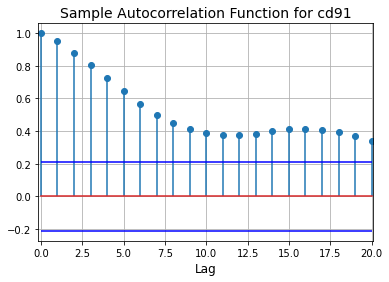

In [7]:
res.plot_acf()

출력된 이미지는 $h=0,...,20$이라는 시차 각각에 대한 표본 자기상관함수 (빨간점들)와 2 표준오차 이내의 신뢰구간 (파란선)을 나타낸다. 이때 모든 ACF들이 신뢰구간을 벗어나기 때문에 5\% 유의수준 하에서 변수가 백색잡음과정이라는 귀무가설이 기각된다고 해석할 수 있다.

그렇다면 만약 모든 ACF들이 신뢰구간 안에 포함된다면 해당 변수가 백색잡음과정이라고 결론을 내릴 수 있을까? 예를들어, 아래와 같이 전기 대비 실질GDP의 성장률을 동일한 귀무가설 하에서 검정한다면 다음과 같은 이미지가 출력된다.

In [8]:
x = df.loc['2001-12-31':, 'rgdp']
res_gdp = autocor(x)

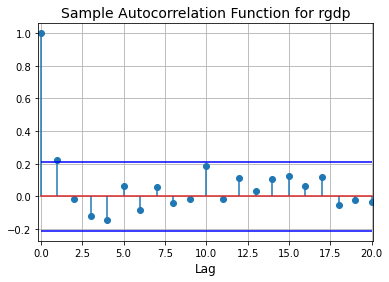

In [9]:
res_gdp.plot_acf()

비록 $h=0$일때 ACF가 신뢰구간을 벗어나지만, 나머지 시차의 ACF들은 신뢰구간 안에 포함되어 전기 대비 실질 GDP 성장률이라는 변수가 백색잡음과정인 것처럼 보인다. 하지만 이는 잘못된 해석이다. 왜냐하면, 신뢰구간은 단순 가설검정의 결과로 이를 모든 시차에 대해서 반복하게 된다면 1종 오류 (귀무가설이 옳음에도 불구하고 검정통계량에 따라 귀무가설을 기각하는 판단을 내리는 것)의 가능성이 항상 존재하기 때문이다.

## 4. 백색잡음과정 결합 가설 검정 (Box-Pierce 검정 및 Ljung-Box 검정)
#### 구문
`bok_da` 라이브러리-시계열분석 패키지(`ts`)-시계열 검정 서브패키지(`test`)의 `white_noise` 함수를 사용하면 백색잡음과정에 대한 결합 가설 검정을 수행할 수 있다. 이때, `white_noise` 함수는 다음과 구성되어 있다.

> *<p style="font-size:15px">`res = white_noise(X, tau_max=None)`</p>*
> *<p style="font-size:15px">백색잡음과정 결합 가설 검정(Box-Pierce와 Ljung-Box 검정)</p>*
> - **입력**:
</br>
    X: 추정하고자하는 변수(단변수)
    </br>
    tau_max: 추정에 사용하는 최대 시차 (default = 20)
    </br>
> - **출력**:
</br>
    box_pierce: Box-Pierce 통계량 값
    </br>
    pval_bp: Box-Pierce 통계량의 p-값
    </br>
    ljung_box: Ljung-Box 통계량 값
    </br>
    pval_lb: Ljung-Box 통계량의 p-값
    </br>

#### 이론
위 단순 가설 검정으로 백색잡음과정을 검정하였을 때, 발생할 수 있는 문제로 인해 다음과 같이 결합 가설 검정을 통해 사용하는 변수가 백색잡음과정인지 검정을 시행해볼 수 있다. 이때 사용하는 검정통계량에 따라서 Box-Pierce 검정과 Ljung-Box 검정이라고 부른다.

우선 결합가설검정의 귀무가설과 대안가설은 다음과 같다.
$\begin{equation}
    \begin{cases}
        H_{0}\text{: }\rho(1)=\cdots=\rho(h)=0 \\
        H_{1}\text{: }\rho(s)\neq 0\text{ for some }1\leq s\leq h
    \end{cases} \tag{7}
\end{equation}$
나아가 **Box-Pierce 통계량**은
$\begin{equation}
    Q = T\cdot\sum_{\tau=1}^{h}{\hat{\rho}(\tau)^{2}} \tag{8}
\end{equation}$
이며, **Ljung-Box 통계량**은
$\begin{equation}
    Q = T\cdot(T+2)\cdot\sum_{\tau=1}^{h}{(T-\tau)^{-1}\cdot\hat{\rho}(\tau)^{2}} \tag{8}
\end{equation}$
과 같다.

### (예시)
다시 CD91일 금리 및 전기 대비 실질 GDP 성장률에 대해 위와 같은 결합가설검정을 진행하면 다음과 같은 결과를 얻을 수 있다.

In [10]:
from bok_da.ts.test import white_noise

In [11]:
res_wn = white_noise(y)

res_wn 인스턴스는 다음의 결과를 포함한다.
- `box_pierce` : Box-Pierce 통계량 값
- `pval_bp` : Box-Pierce 통계량의 p-값
- `ljung_box` : Ljung-Box 통계량 값
- `pval_lb` : Ljung-Box 통계량의 p-값

res_wn 인스턴스의 get_table 메서드를 이용해서 결과를 출력한다.

In [12]:
res_wn.get_table()

       Box-Pierce  Ljung-Box
stat      521.884   580.9286
p-val       0.000     0.0000
 
H0:r(1)=r(2)=...r(h)=0; 백색잡음과정이다.
유의수준 < p-값 = 유의수준 하에서 귀무가설 (H0)을 기각, i.e. 백색잡음과정이 아니다.


rgdp에 대해서도 동일한 작업을 수행한다.

In [13]:
res_gdp = white_noise(x)

In [14]:
res_gdp.get_table()

       Box-Pierce  Ljung-Box
stat      17.4763    19.7040
p-val      0.6219     0.4766
 
H0:r(1)=r(2)=...r(h)=0; 백색잡음과정이다.
유의수준 < p-값 = 유의수준 하에서 귀무가설 (H0)을 기각, i.e. 백색잡음과정이 아니다.


결과를 해석하면 우선 CD91일 금리에 대해서는 BP 검정이나 LB 검정 모두 p값이 0으로 나와 매우 보수적인 1\% 유의수준 하에서도 변수가 백색잡음이라는 귀무가설을 기각한다는 것을 알 수 있다. 반면 전년 대비 실질 GDP 성장률에 대해서는 BP 검정이나 LB 검정 모두 5\% 유의수준 하에서 변수가 백색잡음이라는 귀무가설을 기각하지 못하여 변수를 백색잡음으로 해석할 수 있다.